In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [5]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

#data_path = "../dataset/TSmall"
#postfix = "TSmall"
#dim = 70
data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

molecules = (molecules[:ind], molecules[ind:])

ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Model 

In [4]:
filepath = "../../models/" + "TSmall_sto3gmodelTSmall_sto3g_250-150-50+triu.h5"
model = keras.models.load_model(filepath)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 351)               123552    
_________________________________________________________________
dense_1 (Dense)              (None, 601)               211552    
_________________________________________________________________
dense_2 (Dense)              (None, 501)               301602    
_________________________________________________________________
dense_3 (Dense)              (None, 401)               201302    
_________________________________________________________________
dense_4 (Dense)              (None, 351)               141102    
Total params: 979,110
Trainable params: 979,110
Non-trainable params: 0
_________________________________________________________________


# Utilites 

In [31]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer


def make_curve(ps):
    e = []
    it = []
    
    for (p, mol) in zip(ps, molecules[1]):
        mf = mf_initializer(mol.get_pyscf_molecule())
        e.append(mf.scf(dm0=p))
        it.append(mf.iterations)
        
    return e, it

# NN

In [32]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch
p_nn = make_matrix_batch(model.predict(s_test), dim, is_triu=True).astype("float64")

curve_nn = make_curve(p_nn)

# Classical Guesses

In [33]:
from pyscf.scf import hf

p_1e = np.array([
    hf.init_guess_by_1e(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [34]:
curve_1e = make_curve(p_1e)
curve_sad = make_curve(p_sad)
curve_gwh = make_curve(p_gwh)

# Plot 

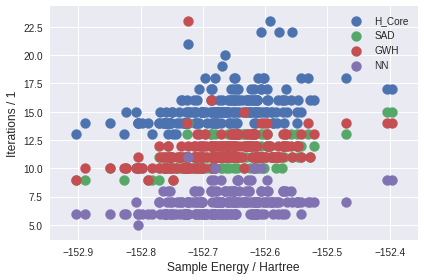

In [37]:
plt.scatter(*curve_1e, label="H_Core")
plt.scatter(*curve_sad, label="SAD")
plt.scatter(*curve_gwh, label="GWH")
plt.scatter(*curve_nn, label="NN")

plt.xlabel("Sample Energy / Hartree")
plt.ylabel("Iterations / 1")

plt.legend()

plt.tight_layout()

plt.savefig("/home/jcartus/Repos/MastersThesis/SMatrixDescriptor/figures/IterationsVsEnergy.pdf")

plt.show()